## Threshold for condition:
We want to decide wether a problem is unique or non unique depending on this threshold.

### Non uniqueness

 We choose the threshoold $T$ as 
 $$T = \frac{\tilde{\sigma}_1}{\sqrt{E}} $$
where $E = m(C_m \frac{\epsilon}{h} + h^{order} M C_a)^2 + \|u-\tilde{u}\|_2^2$ and $\epsilon = \|u-u_{noise}\|_{\infty} + 10^{-16}$ and $h=dx$. If a value is bigger than T the function u should be nonunique.

In [1]:
import numpy as np
from numpy.linalg import matrix_rank, svd
from test_data import experiment_data,add_noise,create_data_2d
import pysindy as ps
import matplotlib.pyplot as plt

In [2]:
"""
n: number of data points used for approximation/ order
k: number of lagrange coefficient
l: input to lagrange coefficient: x = x_l = x+ hl
"""
#Computes the coefficients of the derivitve of the kth Lagrangian Coefficients
#These are also the coefficients used for finite differences
def lagrange_coefficient_derivative(n,k,l):
    erg=0.0        
    for j in range(n+1):
        if j!=k:
            tmp =1.0
            for i in range(n+1):
                  if i!=k and i!=j:
                    tmp *=(l-i)/(k-i)
                    #print(f"l-k = {l}-{i}")
            tmp*=1.0/(k-j)
            erg+=tmp
    return erg
    
#Sums up the above coefficients
#needed for measurment error
def sum_lagrange_coefficient_derivative(n,l):
    erg=0.0
    for k in range(n+1):
        #print(f"L({n},{k},{l}) = {lagrange_coefficient_derivative(n,k,l)}")
        erg+= np.abs(lagrange_coefficient_derivative(n,k,l))
    return erg

# Approximation error central differences: reduces with higher order n
def appr_error_central_diff(n):
    assert(n%2==0) #Check if n is even
    bound = (np.math.factorial(int(n/2))**2)/np.math.factorial(n+1)
    return bound
    
# Approximation error backward differences: reduces with higher order n
def appr_error_backward_diff(n):
    return 1/(n+1)

# Measurement error central differences
def meas_error_central_diff(n):
    assert(n%2==0) #Check if n is even
    erg=sum_lagrange_coefficient_derivative(n,n/2)
    return erg
    
# Measurement error backward differences
def meas_error_backward_diff(n):
    erg=sum_lagrange_coefficient_derivative(n,0)
    return erg



"""
eps: measurement error+round of error (Does it make sense to add machine precision?)
h: dx for equispaced data
M: bound on (order+1)th derivative
"""
def error_bound(eps,h,M,order=2):
    eps+=np.finfo(float).eps # add machine precisoin
    if order%2==0: #even order
        C_app=appr_error_central_diff(order)
        C_meas=meas_error_central_diff(order)
    else: # odd order
        C_app=appr_error_backward_diff(order)
        C_meas=meas_error_backward_diff(order)
    #print(f" C_meas*eps/h + (h**order)*M*C_app = {C_meas:2.3e}*{eps:2.3e}/{h:2.3e} + {h**order:2.3e}*{M:2.3e}*{C_app:2.3e}")    
    return C_meas*eps/h + (h**order)*M*C_app
            
def infinity_norm(x):
    return np.max(np.abs(x))

"""
eps_two: ||u-u_noise||_2 two norm
eps_infty: ||u-u_noise||_infty infinity norm
h: dx for equispaced data
number_datapoints: number of total datapoints where u is evaluated
M: bound on nth derivative depending on the order
"""
def error_bound_g(eps_two,eps_infty,h,number_datapoints,M,order):
    E = eps_two**2 + number_datapoints*error_bound(eps_infty,h,M,order)**2
    return E


In [3]:
def calc_threshold(eps,h,number_datapoints,order=2):
    eps+=np.finfo(float).eps # add machine precisoin
    if order%2==0: #even order
        C_meas=meas_error_central_diff(order)
    else: # odd order
        C_meas=meas_error_backward_diff(order)
    return 1/(eps/h+h**order)

def calc_threshold2(omax,eps_two,eps_infty,h,number_datapoints,M,order=2): 
    E = error_bound_g(eps_two,eps_infty,h,number_datapoints,M,order)
    return omax/np.sqrt(E)

In [4]:
n_samples=50
T,X,t,x = create_data_2d(T_start=-5, T_end=1, L_x_start=0,L_x_end=1, N_t=n_samples, N_x=n_samples)
a=np.random.randn()

u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u

dx=x[1]-x[0]

In [5]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_max/sv_min:3.3e}")

M: 3.1881893118585953
Singular values of g: (99.54470737054774, 8.115851550960189e-15)
sv_max/sv_min: 1.227e+16


In [6]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_max/sv_min:3.3e}")

M: 3.1881893118585953
Singular values of g: (99.54470737054774, 8.115851550960189e-15)
sv_max/sv_min: 1.227e+16


True ratio: 1.227e+16
Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0
0.0
	  	 2 	 	 4.352e+04 	 2.401e+03 	 8.996e+03
	  	 3 	 	 4.214e+06 	 1.176e+05 	 2.939e+05
	  	 4 	 	 2.803e+08 	 5.765e+06 	 1.080e+08
	  	 5 	 	 1.416e+10 	 2.825e+08 	 1.058e+09
	  	 6 	 	 8.503e+11 	 1.384e+10 	 1.196e+12
	  	 7 	 	 5.261e+13 	 6.733e+11 	 1.829e+12
	  	 8 	 	 8.381e+13 	 2.441e+13 	 8.725e+13
	  	 9 	 	 4.646e+13 	 8.700e+13 	 1.356e+12


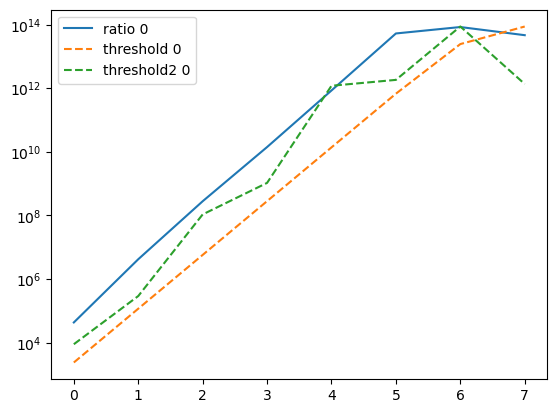

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-10
6.934357099966087e-09
	  	 2 	 	 4.352e+04 	 2.401e+03 	 8.995e+03
	  	 3 	 	 4.213e+06 	 1.173e+05 	 2.866e+05
	  	 4 	 	 2.051e+08 	 5.016e+06 	 3.476e+07
	  	 5 	 	 2.110e+08 	 3.397e+07 	 4.485e+06
	  	 6 	 	 1.549e+08 	 3.851e+07 	 4.193e+07
	  	 7 	 	 1.011e+08 	 3.861e+07 	 1.670e+06
	  	 8 	 	 6.392e+07 	 3.861e+07 	 3.690e+07
	  	 9 	 	 3.882e+07 	 3.861e+07 	 5.698e+05


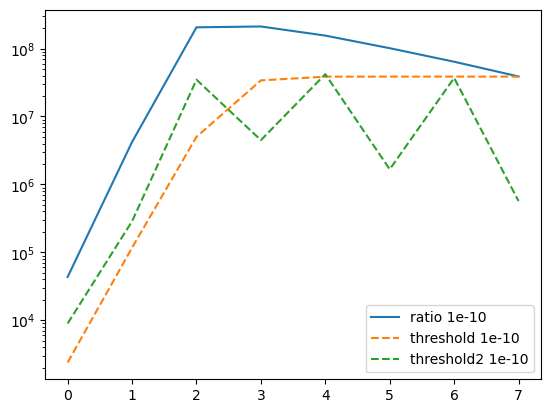

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-09
6.893237130035978e-08
	  	 2 	 	 4.352e+04 	 2.400e+03 	 8.986e+03
	  	 3 	 	 4.174e+06 	 1.143e+05 	 2.361e+05
	  	 4 	 	 2.735e+07 	 2.369e+06 	 5.088e+06
	  	 5 	 	 2.015e+07 	 3.967e+06 	 4.691e+05
	  	 6 	 	 1.513e+07 	 4.022e+06 	 4.369e+06
	  	 7 	 	 1.016e+07 	 4.023e+06 	 1.740e+05
	  	 8 	 	 6.482e+06 	 4.023e+06 	 3.845e+06
	  	 9 	 	 3.883e+06 	 4.023e+06 	 5.937e+04


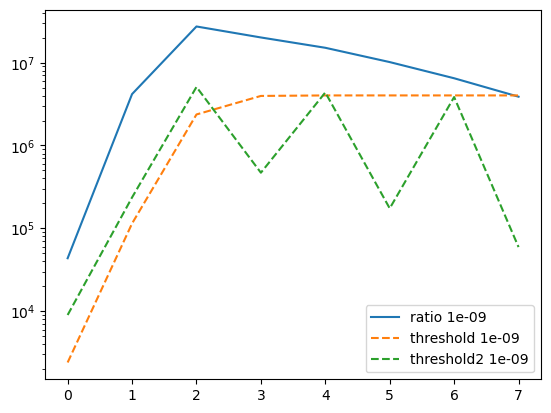

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-08
7.11570271917023e-07
	  	 2 	 	 4.352e+04 	 2.388e+03 	 8.902e+03
	  	 3 	 	 2.346e+06 	 9.215e+04 	 8.865e+04
	  	 4 	 	 2.582e+06 	 3.959e+05 	 5.613e+05
	  	 5 	 	 1.875e+06 	 4.245e+05 	 4.959e+04
	  	 6 	 	 1.387e+06 	 4.251e+05 	 4.616e+05
	  	 7 	 	 9.191e+05 	 4.251e+05 	 1.839e+04
	  	 8 	 	 5.836e+05 	 4.251e+05 	 4.062e+05
	  	 9 	 	 3.546e+05 	 4.251e+05 	 6.273e+03


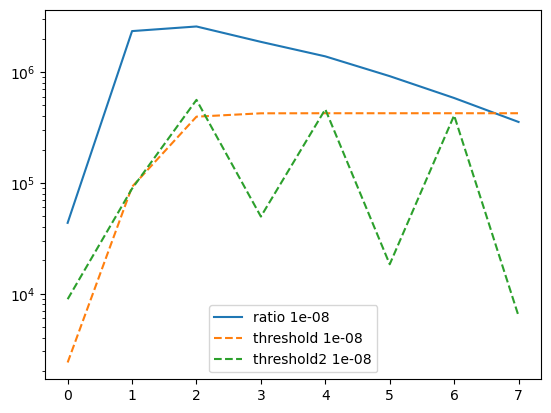

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-07
7.045099024384175e-06
	  	 2 	 	 4.361e+04 	 2.271e+03 	 8.119e+03
	  	 3 	 	 2.910e+05 	 3.085e+04 	 1.198e+04
	  	 4 	 	 2.811e+05 	 4.152e+04 	 5.548e+04
	  	 5 	 	 2.061e+05 	 4.181e+04 	 4.878e+03
	  	 6 	 	 1.550e+05 	 4.182e+04 	 4.541e+04
	  	 7 	 	 1.010e+05 	 4.182e+04 	 1.809e+03
	  	 8 	 	 6.126e+04 	 4.182e+04 	 3.996e+04
	  	 9 	 	 3.485e+04 	 4.182e+04 	 6.171e+02


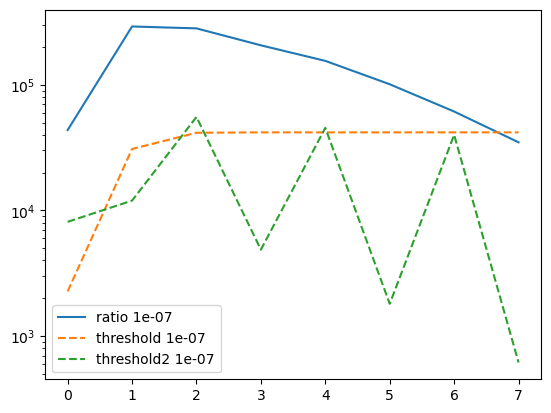

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-06
7.045601810555509e-05
	  	 2 	 	 3.176e+04 	 1.481e+03 	 4.149e+03
	  	 3 	 	 2.906e+04 	 3.744e+03 	 1.150e+03
	  	 4 	 	 2.657e+04 	 3.865e+03 	 5.133e+03
	  	 5 	 	 1.891e+04 	 3.868e+03 	 4.512e+02
	  	 6 	 	 1.401e+04 	 3.868e+03 	 4.200e+03
	  	 7 	 	 9.477e+03 	 3.868e+03 	 1.673e+02
	  	 8 	 	 6.137e+03 	 3.868e+03 	 3.696e+03
	  	 9 	 	 3.717e+03 	 3.868e+03 	 5.708e+01


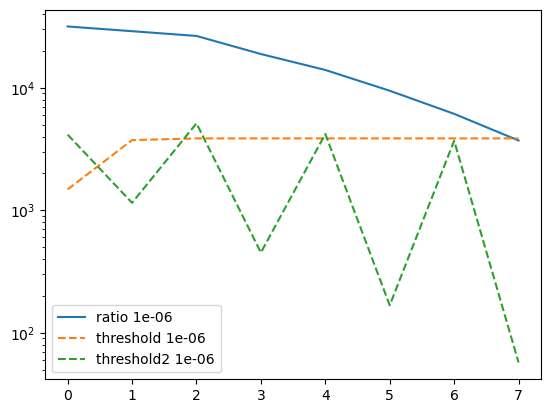

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-05
0.0007090693387808678
	  	 2 	 	 4.756e+03 	 3.315e+02 	 7.058e+02
	  	 3 	 	 2.941e+03 	 3.834e+02 	 1.148e+02
	  	 4 	 	 2.796e+03 	 3.846e+02 	 5.105e+02
	  	 5 	 	 2.021e+03 	 3.847e+02 	 4.487e+01
	  	 6 	 	 1.523e+03 	 3.847e+02 	 4.177e+02
	  	 7 	 	 1.027e+03 	 3.847e+02 	 1.664e+01
	  	 8 	 	 6.665e+02 	 3.847e+02 	 3.676e+02
	  	 9 	 	 4.080e+02 	 3.847e+02 	 5.677e+00


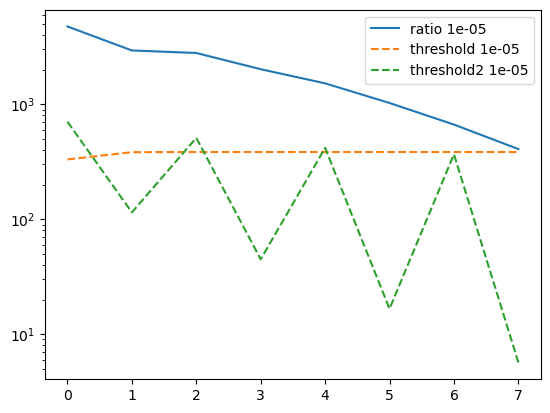

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.0001
0.007040371287453664
	  	 2 	 	 4.723e+02 	 4.311e+01 	 8.655e+01
	  	 3 	 	 2.882e+02 	 4.388e+01 	 1.311e+01
	  	 4 	 	 2.619e+02 	 4.390e+01 	 5.826e+01
	  	 5 	 	 1.834e+02 	 4.390e+01 	 5.121e+00
	  	 6 	 	 1.317e+02 	 4.390e+01 	 4.767e+01
	  	 7 	 	 8.654e+01 	 4.390e+01 	 1.899e+00
	  	 8 	 	 5.540e+01 	 4.390e+01 	 4.197e+01
	  	 9 	 	 3.442e+01 	 4.390e+01 	 6.485e-01


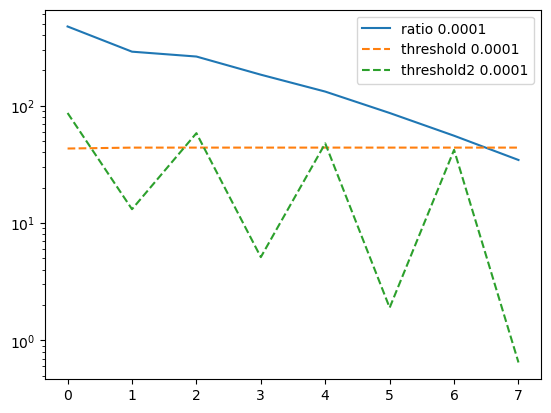

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.001
0.06967542097161587
	  	 2 	 	 4.886e+01 	 3.628e+00 	 7.229e+00
	  	 3 	 	 2.996e+01 	 3.634e+00 	 1.086e+00
	  	 4 	 	 2.801e+01 	 3.634e+00 	 4.826e+00
	  	 5 	 	 2.030e+01 	 3.634e+00 	 4.244e-01
	  	 6 	 	 1.525e+01 	 3.634e+00 	 3.954e+00
	  	 7 	 	 1.012e+01 	 3.634e+00 	 1.579e-01
	  	 8 	 	 6.331e+00 	 3.634e+00 	 3.517e+00
	  	 9 	 	 3.869e+00 	 3.634e+00 	 5.577e-02


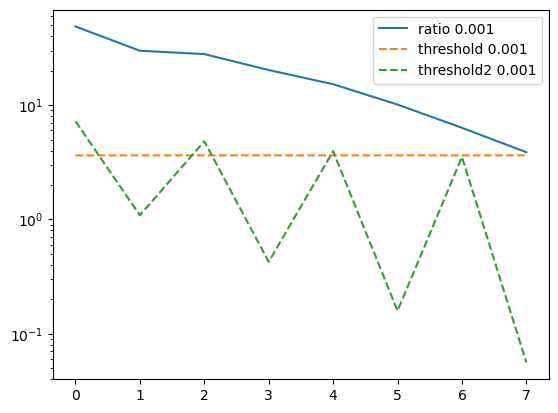

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.01
0.7173632056206494
	  	 2 	 	 4.995e+00 	 4.241e-01 	 8.660e-01
	  	 3 	 	 3.307e+00 	 4.242e-01 	 1.350e-01
	  	 4 	 	 3.194e+00 	 4.242e-01 	 6.049e-01
	  	 5 	 	 2.636e+00 	 4.242e-01 	 5.657e-02
	  	 6 	 	 2.429e+00 	 4.242e-01 	 5.801e-01
	  	 7 	 	 2.576e+00 	 4.242e-01 	 2.896e-02
	  	 8 	 	 3.373e+00 	 4.242e-01 	 9.133e-01
	  	 9 	 	 5.207e+00 	 4.242e-01 	 2.258e-02


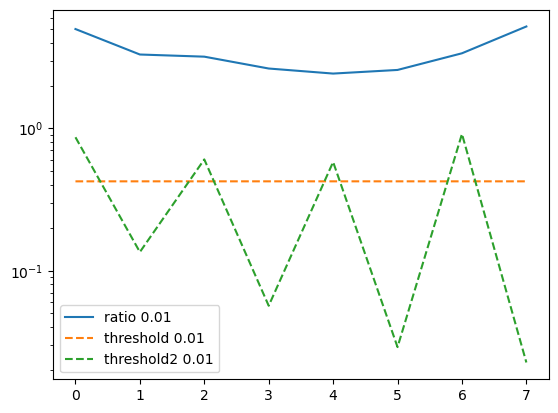

In [7]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,10,1)
print(f"True ratio: {sv_max/sv_min:3.3e}")
unorm2=np.sqrt(np.mean(np.square(u)))

for target_noise in noise_levels:
    print("Noise level \t order \t \t ratio \t \t threshold \t threshold2")
    print(f"{target_noise}")
    threshold_list = []
    threshold2_list = []
    ratio_list=[]
    
    var = target_noise * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    print(np.linalg.norm(noise))
    u_noise = u + noise
    eps_infty = infinity_norm(u-u_noise)
    eps_two = np.linalg.norm(u-u_noise)
    
    for order in orders:          
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        
        ratio=sv[0]/sv[-1]
        threshold = calc_threshold(eps_infty,dx,true_g.shape[0],order)
        threshold_list.append(threshold)
        threshold2 = calc_threshold2(sv[0],eps_two,eps_infty,dx,true_g.shape[0],M,order)
        threshold2_list.append(threshold2)
        ratio_list.append(ratio)
        
        print(f"\t  \t {order} \t \t {ratio:3.3e} \t {threshold:3.3e} \t {threshold2:3.3e}")
    
    plt.plot(ratio_list,label=f'ratio {target_noise}')
    plt.plot(threshold_list,'--',label=f'threshold {target_noise}')
    plt.plot(threshold2_list,'--',label=f'threshold2 {target_noise}')
    plt.yscale('log')
    plt.legend()
    plt.show()

### Uniqueness

##### We try a threshold for unqiue values
We choose $C_1>0$ and $C_2>0$ such that $\sigma_1 \leq C_1 ,\sigma_n \geq \frac{1}{C_2}  $. Then
$$\frac{\tilde\sigma_1}{\tilde\sigma_n} \leq C_1 C_2+ C_2 \sqrt{1 + (C_2 C_1)^2}\|G-\tilde{G}\|_F \leq C_1 C_2+ C_2 \sqrt{1 + (C_2 C_1)^2}\sqrt{E}$$
The ideal $C_1, C_2$ would be $C_1 = \sigma_1, C_2 = \frac{1}{\sigma_n}$. However, in practice we do not know the true singular valuse. Thus, we can educately guess these bounds with:
$$C_1=\tilde\sigma_1+\sqrt{eps/h+h^{order}}, \ C_2=\frac{1}{\tilde\sigma_n-\sqrt{eps/h+h^{order}}}$$
This approximates deviation we get from the derivative calculation.

In [8]:
"""
u: function with noise
eps: noise estimation infinity_norm(u-u_noise)
"""
def educated_guess_c1c2(u,eps,h):
    #Calculate omin omax
    ux= ps.FiniteDifference(order=2,d=1, axis=0, drop_endpoints=False)._differentiate(u, h)
    u_flat, u_x_flat = u.flatten(), ux.flatten()
    g = np.concatenate([u_flat.reshape(len(u_flat),1), u_x_flat.reshape(len(u_flat),1)], axis=1)
    sv = svd(g, compute_uv=False)
    omax,omin = sv[0],sv[-1]
    print(omax,omin)
    #Calculate C1,C2    
    E = (eps/h+h**order)
    C1= omax+ np.sqrt(E)
    assert omin - np.sqrt(E) >0
    C2= 1/(omin - np.sqrt(E))
    return C1,C2

"""
This calculates the threshold with minimal knowlegdede
C1: upper bound o1 <= C1
C2: lower bound on >= 1/C2
eps: noise estimation infinity_norm(u-u_noise)
h: dx
order: order of the derivative caluclation
"""
def calc_threshold_uniq(C1,C2,eps,h,order=2):
    E = (eps/h+h**order)
    T = C1*C2 + C2*np.sqrt(1+ (C1*C2)**2)*np.sqrt(E)
    return T
##This function calculates the threshold with all constants (we do not normally know)
def calc_threshold_uniq2(C1,C2,eps_two,eps_infty,M,h,number_datapoints,order=2):
    E = error_bound_g(eps_two,eps_infty,h,number_datapoints,M,order)
    T = C1*C2 + C2*np.sqrt(1+ (C1*C2)**2)*np.sqrt(E)
    return T

In [9]:
n_samples=100
T,X,t,x = create_data_2d(T_start=0, T_end=1, L_x_start=-2,L_x_end=3, N_t=n_samples, N_x=n_samples)
a=np.random.randn()*1e-6
b=np.random.randn()*1e-3
C=0.1
"""
u = np.cos(X-a*T)*C
ux = -np.sin(X-a*T)*C
uxx = -np.cos(X-a*T)*C
uxxx = np.sin(X-a*T)*C
ut = a*np.sin(X-a*T)*C
"""
"""
u=(X+b*T)*np.exp(a*T)
ux = np.exp(a*T)
uxx= 1
uxxx= 0
ut= b*np.exp(a*T) + a*(X*+b*T)*np.exp(a*T) #bux + aut
"""
u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u

dx=x[1]-x[0]

In [10]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_max/sv_min:3.3e}")

M: 20.085536923187668
Singular values of g: (916.3928951981352, 6.414039108903035e-14)
sv_max/sv_min: 1.429e+16


In [11]:
#Best choice C1 C2
C1=sv_max
C2=1/sv_min
print(f"C1: {C1}, C2: {C2}")

C1: 916.3928951981352, C2: 15590799853589.068


True ratio: 1.429e+16
Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0
0.0
916.5329709637278 0.16795302786133792
C1: 916.5329724259274, C2: 5.954097516504882
	  	 2 	 	 5.457e+03 	 7.098e+03 	 3.320e+04
	  	 3 	 	 2.292e+05 	 5.826e+03 	 7.559e+03
	  	 4 	 	 5.918e+06 	 5.540e+03 	 5.471e+03
	  	 5 	 	 1.224e+08 	 5.476e+03 	 5.461e+03
	  	 6 	 	 3.050e+09 	 5.461e+03 	 5.457e+03
	  	 7 	 	 7.531e+10 	 5.458e+03 	 5.457e+03
	  	 8 	 	 1.613e+12 	 5.457e+03 	 5.457e+03
	  	 9 	 	 1.415e+13 	 5.457e+03 	 5.457e+03


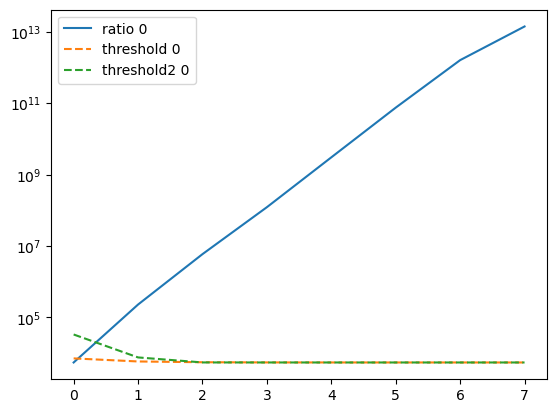

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-10
6.382184999641045e-08
916.532970967534 0.1679530254942921
C1: 916.5331958557222, C2: 5.9620288883000745
	  	 2 	 	 5.457e+03 	 7.110e+03 	 3.328e+04
	  	 3 	 	 2.292e+05 	 5.836e+03 	 7.573e+03
	  	 4 	 	 5.916e+06 	 5.555e+03 	 5.479e+03
	  	 5 	 	 1.190e+08 	 5.506e+03 	 5.471e+03
	  	 6 	 	 4.797e+08 	 5.501e+03 	 5.465e+03
	  	 7 	 	 3.346e+08 	 5.501e+03 	 5.472e+03
	  	 8 	 	 2.186e+08 	 5.501e+03 	 5.465e+03
	  	 9 	 	 1.330e+08 	 5.501e+03 	 5.487e+03


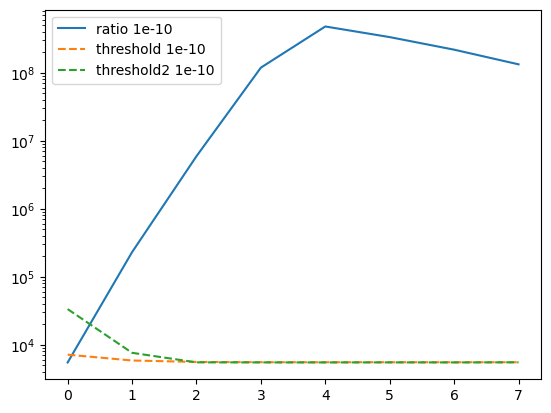

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-09
6.48705535396209e-07
916.5329709426322 0.16795302075332363
C1: 916.5336791502036, C2: 5.979258674598498
	  	 2 	 	 5.457e+03 	 7.139e+03 	 3.346e+04
	  	 3 	 	 2.293e+05 	 5.870e+03 	 7.611e+03
	  	 4 	 	 5.922e+06 	 5.624e+03 	 5.497e+03
	  	 5 	 	 5.322e+07 	 5.599e+03 	 5.512e+03
	  	 6 	 	 4.535e+07 	 5.598e+03 	 5.483e+03
	  	 7 	 	 3.111e+07 	 5.598e+03 	 5.556e+03
	  	 8 	 	 2.076e+07 	 5.598e+03 	 5.484e+03
	  	 9 	 	 1.312e+07 	 5.598e+03 	 5.702e+03


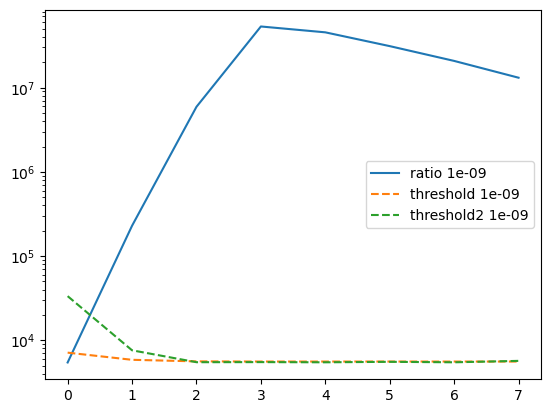

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-08
6.429556646068669e-06
916.5329715548925 0.16795091517174324
C1: 916.5352187462382, C2: 6.034867394108867
	  	 2 	 	 5.457e+03 	 7.259e+03 	 3.405e+04
	  	 3 	 	 2.293e+05 	 6.065e+03 	 7.803e+03
	  	 4 	 	 4.888e+06 	 5.917e+03 	 5.571e+03
	  	 5 	 	 6.090e+06 	 5.908e+03 	 5.823e+03
	  	 6 	 	 4.939e+06 	 5.908e+03 	 5.562e+03
	  	 7 	 	 3.360e+06 	 5.908e+03 	 6.307e+03
	  	 8 	 	 2.158e+06 	 5.908e+03 	 5.566e+03
	  	 9 	 	 1.285e+06 	 5.908e+03 	 7.805e+03


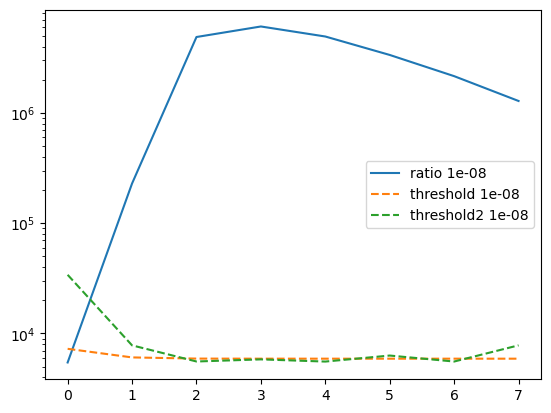

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-07
6.495660785367381e-05
916.5329620424598 0.16797989835773336
C1: 916.540052014781, C2: 6.215429546369779
	  	 2 	 	 5.456e+03 	 7.890e+03 	 3.611e+04
	  	 3 	 	 2.192e+05 	 7.029e+03 	 9.174e+03
	  	 4 	 	 8.122e+05 	 6.970e+03 	 5.979e+03
	  	 5 	 	 6.039e+05 	 6.967e+03 	 8.738e+03
	  	 6 	 	 4.863e+05 	 6.967e+03 	 6.023e+03
	  	 7 	 	 3.323e+05 	 6.966e+03 	 1.389e+04
	  	 8 	 	 2.169e+05 	 6.966e+03 	 6.067e+03
	  	 9 	 	 1.317e+05 	 6.966e+03 	 2.971e+04


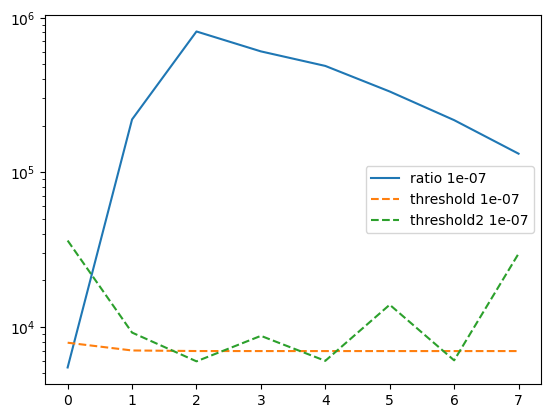

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-06
0.0006410782278029875
916.5329853648241 0.16814420662731838
C1: 916.5556753608591, C2: 6.875015827511341
	  	 2 	 	 5.451e+03 	 1.165e+04 	 4.552e+04
	  	 3 	 	 7.425e+04 	 1.121e+04 	 2.397e+04
	  	 4 	 	 8.423e+04 	 1.118e+04 	 9.666e+03
	  	 5 	 	 6.307e+04 	 1.118e+04 	 4.437e+04
	  	 6 	 	 5.170e+04 	 1.118e+04 	 1.039e+04
	  	 7 	 	 3.502e+04 	 1.118e+04 	 1.089e+05
	  	 8 	 	 2.248e+04 	 1.118e+04 	 1.095e+04
	  	 9 	 	 1.345e+04 	 1.118e+04 	 3.072e+05


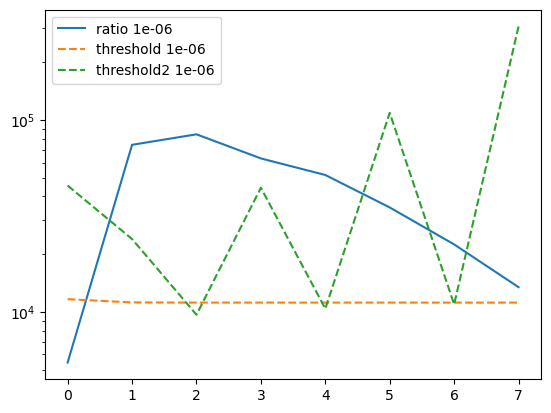

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-05
0.006457477897019999
916.5324199687577 0.18344803691229675
C1: 916.601604256708, C2: 8.751682043382488
	  	 2 	 	 4.996e+03 	 3.337e+04 	 1.016e+05
	  	 3 	 	 7.732e+03 	 3.314e+04 	 2.366e+05
	  	 4 	 	 8.135e+03 	 3.313e+04 	 5.846e+04
	  	 5 	 	 6.079e+03 	 3.312e+04 	 5.815e+05
	  	 6 	 	 4.989e+03 	 3.312e+04 	 6.963e+04
	  	 7 	 	 3.429e+03 	 3.312e+04 	 1.554e+06
	  	 8 	 	 2.211e+03 	 3.312e+04 	 7.803e+04
	  	 9 	 	 1.307e+03 	 3.312e+04 	 4.541e+06


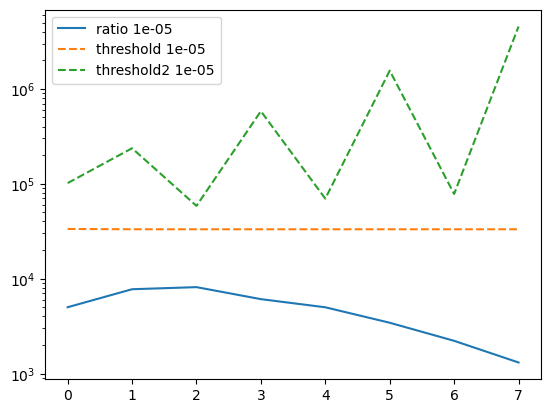

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.0001
0.06567711621414656
916.5458565591778 0.7238570042777727
C1: 916.7804658997984, C2: 2.043954574100579
	  	 2 	 	 1.266e+03 	 6.246e+03 	 2.623e+04
	  	 3 	 	 7.744e+02 	 6.242e+03 	 1.427e+05
	  	 4 	 	 8.124e+02 	 6.242e+03 	 3.350e+04
	  	 5 	 	 5.937e+02 	 6.242e+03 	 3.617e+05
	  	 6 	 	 4.695e+02 	 6.242e+03 	 4.052e+04
	  	 7 	 	 3.135e+02 	 6.242e+03 	 9.720e+05
	  	 8 	 	 1.997e+02 	 6.242e+03 	 4.579e+04
	  	 9 	 	 1.201e+02 	 6.242e+03 	 2.846e+06


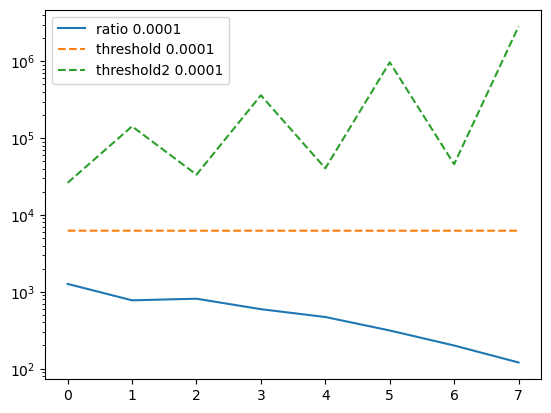

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.001
0.6484440369937156
916.5040046794011 7.141854161633503
C1: 917.2523998134172, C2: 0.1564098550847641
	  	 2 	 	 1.283e+02 	 2.239e+02 	 1.420e+03
	  	 3 	 	 7.791e+01 	 2.239e+02 	 8.524e+03
	  	 4 	 	 8.356e+01 	 2.239e+02 	 2.029e+03
	  	 5 	 	 6.189e+01 	 2.239e+02 	 2.159e+04
	  	 6 	 	 5.002e+01 	 2.239e+02 	 2.448e+03
	  	 7 	 	 3.349e+01 	 2.239e+02 	 5.798e+04
	  	 8 	 	 2.120e+01 	 2.239e+02 	 2.762e+03
	  	 9 	 	 1.251e+01 	 2.239e+02 	 1.697e+05


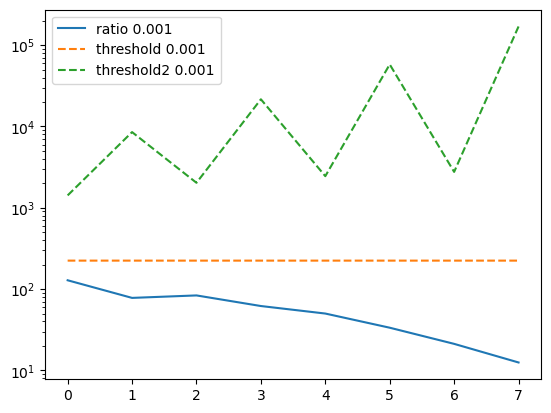

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.01
6.541454132800331
918.4929932290371 72.12455174070132
C1: 920.7797604920769, C2: 0.014318896389387357
	  	 2 	 	 1.273e+01 	 1.534e+01 	 1.124e+02
	  	 3 	 	 7.803e+00 	 1.534e+01 	 6.732e+02
	  	 4 	 	 8.315e+00 	 1.534e+01 	 1.617e+02
	  	 5 	 	 6.196e+00 	 1.534e+01 	 1.703e+03
	  	 6 	 	 5.000e+00 	 1.534e+01 	 1.947e+02
	  	 7 	 	 3.516e+00 	 1.534e+01 	 4.569e+03
	  	 8 	 	 2.641e+00 	 1.534e+01 	 2.195e+02
	  	 9 	 	 2.489e+00 	 1.534e+01 	 1.337e+04


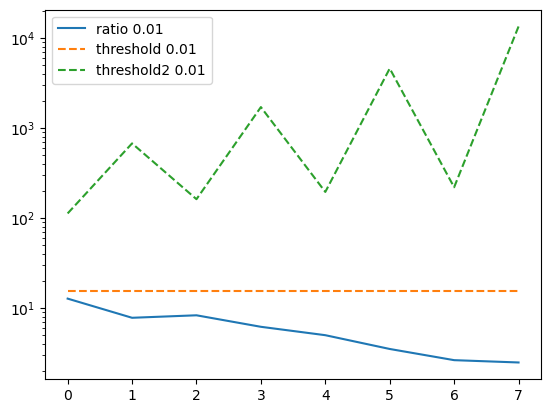

In [12]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,10,1)
print(f"True ratio: {sv_max/sv_min:3.3e}")
unorm2=np.sqrt(np.mean(np.square(u)))


for target_noise in noise_levels:
    print("Noise level \t order \t \t ratio \t \t threshold \t threshold2")
    print(f"{target_noise}")
    
    threshold_list = []
    threshold2_list = []
    ratio_list=[]
    
    var = target_noise * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    print(np.linalg.norm(noise))
    u_noise = u + noise
    eps_two = np.linalg.norm(u-u_noise)
    eps_infty = infinity_norm(u-u_noise)

    #Educated guess for C1 C2
    C1,C2 = educated_guess_c1c2(u_noise,eps_infty,dx)
    print(f"C1: {C1}, C2: {C2}")
    for order in orders:        
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        ratio=sv[0]/sv[-1]
        
        threshold = calc_threshold_uniq(C1,C2,eps_two,dx,order)
        threshold2 = calc_threshold_uniq2(C1,C2,eps_two,eps_infty,M,dx,true_g.shape[0],order)
        threshold_list.append(threshold)
        threshold2_list.append(threshold2)
        ratio_list.append(ratio)

        
        print(f"\t  \t {order} \t \t {ratio:3.3e} \t {threshold:3.3e} \t {threshold2:3.3e}")
    
    plt.plot(ratio_list,label=f'ratio {target_noise}')
    plt.plot(threshold_list,'--',label=f'threshold {target_noise}')
    plt.plot(threshold2_list,'--',label=f'threshold2 {target_noise}')
    plt.yscale('log')
    plt.legend()
    plt.show()

### Combine non uniqueness and uniqueness bound

In [23]:
n_samples=100
T,X,t,x = create_data_2d(T_start=0, T_end=1, L_x_start=-2,L_x_end=3, N_t=n_samples, N_x=n_samples)
a=np.random.randn()
b=np.random.randn()
C=1

u = np.cos(X-a*T)*C
ux = -np.sin(X-a*T)*C
uxx = -np.cos(X-a*T)*C
uxxx = np.sin(X-a*T)*C
ut = a*np.sin(X-a*T)*C

"""
u=(X+b*T)*np.exp(a*T)
ux = np.exp(a*T)
uxx= 1
uxxx= 0
ut= b*np.exp(a*T) + a*(X*+b*T)*np.exp(a*T) #bux + aut

u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u
"""
dx=x[1]-x[0]

u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
frobenius_norm_trueg = np.linalg.norm(true_g)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_max/frobenius_norm_trueg:3.3f}")

M: 0.9999999986401836
Singular values of g: (77.01710697327577, 63.78373800168033)
sv_max/sv_min: 0.770


True ratio: 1.207e+00
Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0
0.0
C: 63.78373800168033, Check 


/tmp/ipykernel_2874292/2408741351.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  return 1/(eps/h+h**order)


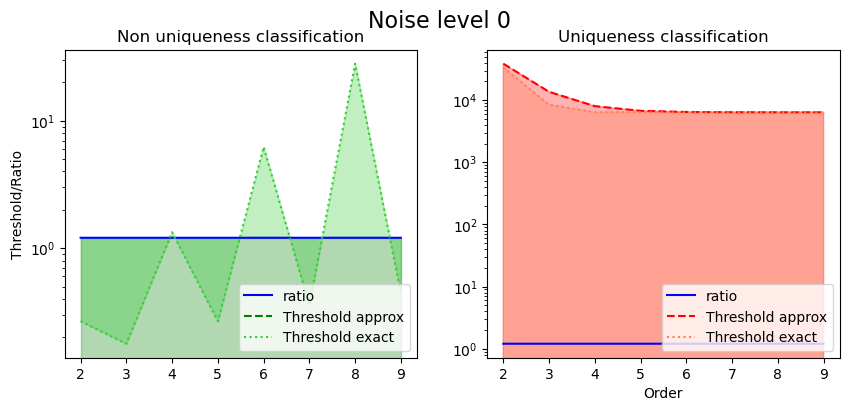

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-10
6.817530603009291e-09
C: 63.78373800168033, Check 


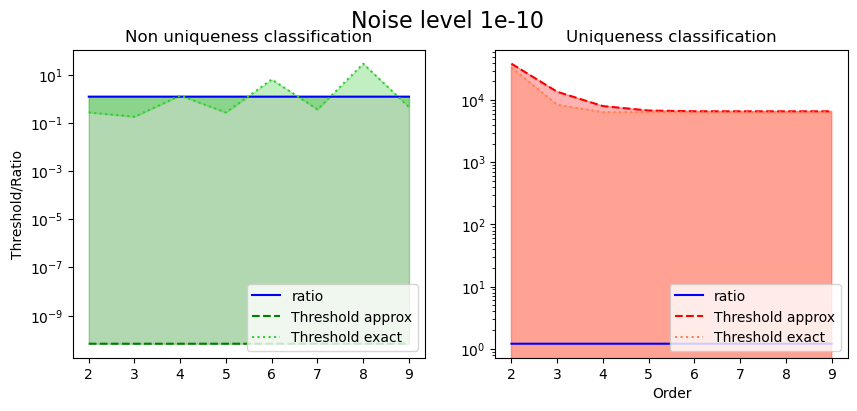

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-09
6.828560242899656e-08
C: 63.78373800168033, Check 


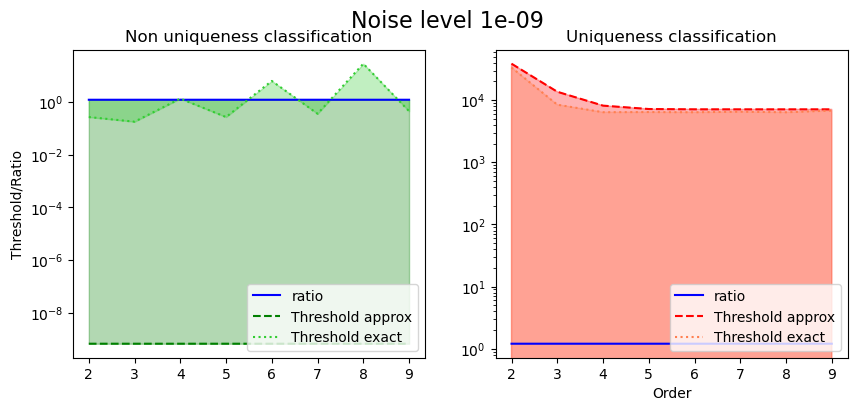

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-08
6.832781431067969e-07
C: 63.78373800168033, Check 


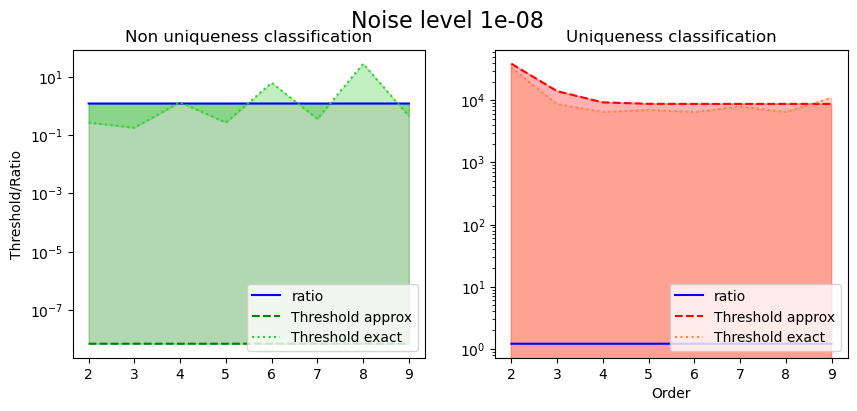

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-07
6.766025316022456e-06
C: 63.78373800168033, Check 


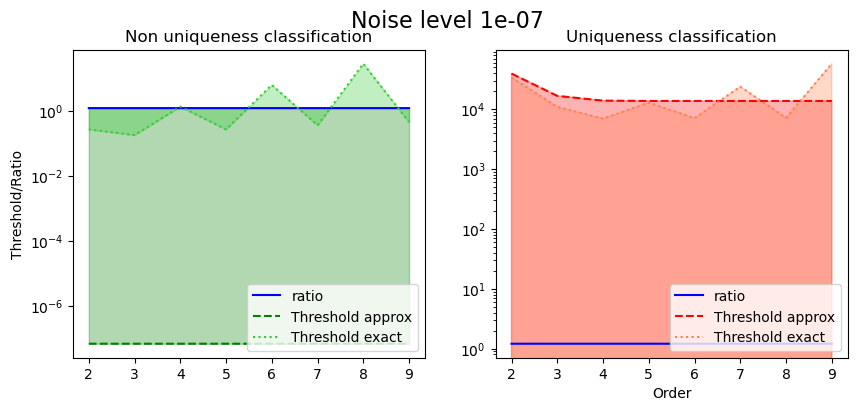

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-06
6.818308758773196e-05
C: 63.78373800168033, Check 


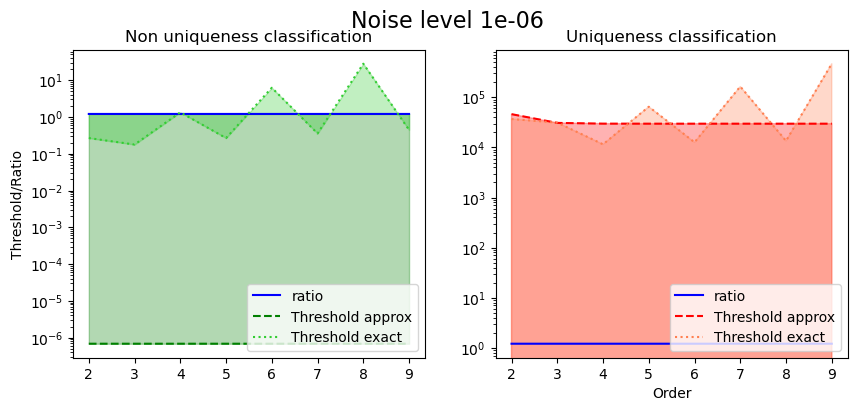

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-05
0.0006772783706271086
C: 63.78373800168033, Check 


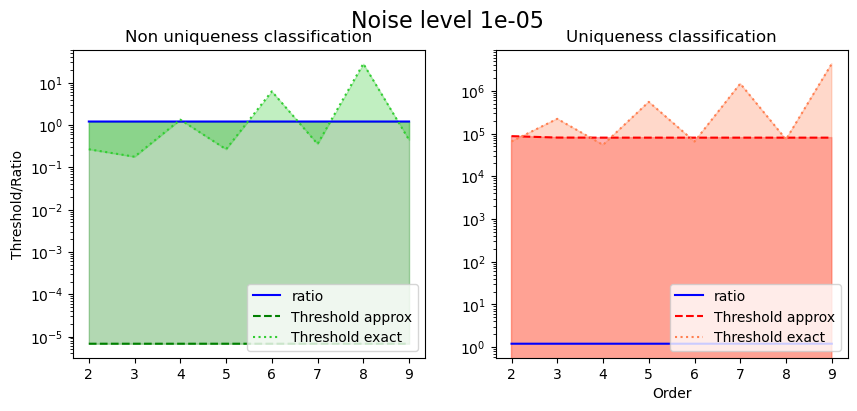

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.0001
0.006749506734492435
C: 63.78373800168033, Check 


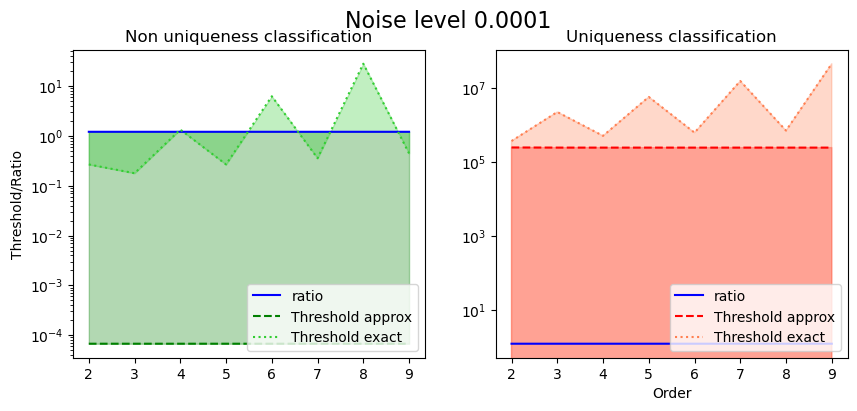

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.001
0.06743337604747653
C: 63.78373800168033, Check 


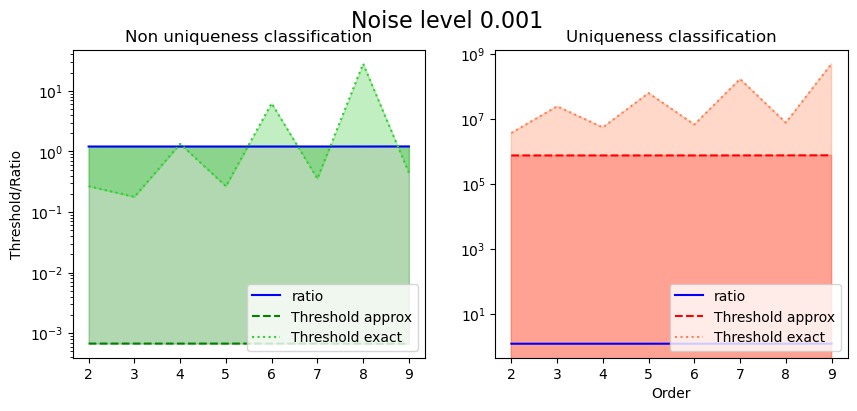

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.01
0.6856316951610211
C: 63.78373800168033, Check 


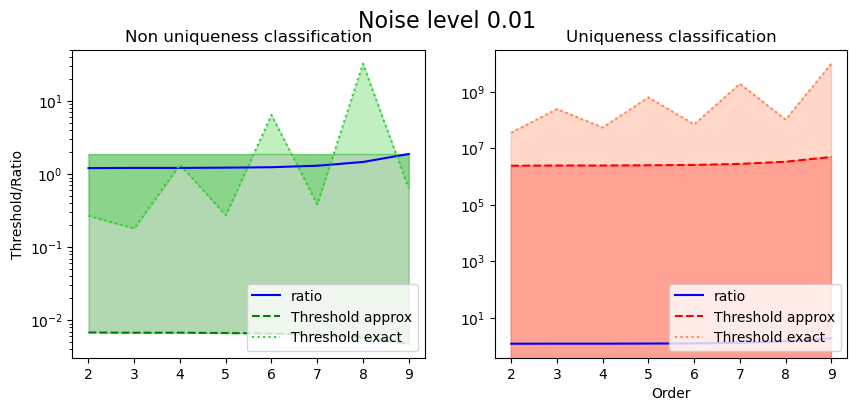

In [24]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,10,1)
print(f"True ratio: {sv_max/sv_min:3.3e}")
unorm2=np.sqrt(np.mean(np.square(u)))
C=sv_min
for target_noise in noise_levels:
    print("Noise level \t order \t \t ratio \t \t threshold \t threshold2")
    print(f"{target_noise}")
    
    threshold_uniq_list = []
    threshold2_uniq_list = []
    threshold_nonunique_list = []
    threshold2_nonunique_list = []
    ratio_list=[]
    
    var = target_noise * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    print(np.linalg.norm(noise))
    u_noise = u + noise
    eps_two = np.linalg.norm(u-u_noise)
    eps_infty = infinity_norm(u-u_noise)

    #Educated guess for C1 C2
    #C = educated_guess_c(u_noise,eps_infty,dx)
    print(f"C: {C}, Check ")
    for order in orders:        
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        frobenius_norm_gnoise=np.linalg.norm(g_noise)
        
        ratio=sv[0]/sv[-1]  
        
        threshold_uniq = calc_threshold_uniq(C,frobenius_norm_gnoise,eps_two,dx,order)
        threshold2_uniq = calc_threshold_uniq2(C,frobenius_norm_gnoise,eps_two,eps_infty,M,dx,true_g.shape[0],order)
        threshold_uniq_list.append(threshold_uniq)
        threshold2_uniq_list.append(threshold2_uniq)
  
        threshold_nonunique = calc_threshold(frobenius_norm_gnoise,eps_two,dx,order)
        threshold2_nonunique = calc_threshold2(frobenius_norm_gnoise,eps_two,eps_infty,M,dx,true_g.shape[0],order)
        threshold_nonunique_list.append(threshold_nonunique)
        threshold2_nonunique_list.append(threshold2_nonunique)
        
        ratio_list.append(ratio)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
    fig.suptitle(f'Noise level {target_noise}', fontsize=16)
    
    # Subplot 1: ratio and green lines
    ax1.set_title("Non uniqueness classification")
    ax1.plot(orders, ratio_list, label='ratio', color='blue')
    ax1.plot(orders, threshold_nonunique_list, '--', label='Threshold approx', color='green')
    ax1.plot(orders, threshold2_nonunique_list, ':', label='Threshold exact', color='limegreen')
    ax1.fill_between(orders, threshold_nonunique_list, y2=np.max(ratio_list), color='green', alpha=0.3)
    ax1.fill_between(orders, threshold2_nonunique_list, y2=np.max(ratio_list), color='limegreen', alpha=0.3)
    ax1.set_yscale('log')
    ax1.set_ylabel('Threshold/Ratio')
    
    # Subplot 2: ratio and red lines
    ax2.set_title("Uniqueness classification")
    ax2.plot(orders, ratio_list, label='ratio', color='blue')
    ax2.plot(orders, threshold_uniq_list, '--', label='Threshold approx', color='red')
    ax2.plot(orders, threshold2_uniq_list, ':', label='Threshold exact', color='coral')
    ax2.fill_between(orders, threshold_uniq_list, color='red', alpha=0.3)
    ax2.fill_between(orders, threshold2_uniq_list, color='coral', alpha=0.3)
    ax2.set_yscale('log')

    
    ax2.set_xlabel('Order')
    ax1.legend(loc=4)
    ax2.legend(loc=4)
    
    plt.show()